In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
db = pd.read_csv('data/med.csv')

# remove subjects with no lottery selections
n_lotery = db[['sub','choice']].groupby('sub').sum()
too_risk_averse = n_lotery[n_lotery['choice']<2].index.values
print("subs to remove for selecting only the ref", too_risk_averse)

db = db[db['sub'].isin(too_risk_averse) == False]


#db['subject'] = db['subn'].astype('category') 

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

#remove awarness check trials (value = 5)
#db = db[db['value']>5]

# get final number of subject and trials
n_subs = db['sub'].unique().shape[0]
print("Final sample includ {} subjects".format(n_subs))

subs to remove for selecting only the ref [65]
Final sample includ 77 subjects


In [3]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

age.columns.values[0] = "sub"
moca.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
print("number of participants with age and moca scores: ",age.shape[0])

number of participants with age and moca scores:  66


In [4]:
db = db.merge(age, left_on='sub', right_on='sub')
db['age'] = db.age.astype('int')
db = db[db.moca_score > 25]
db = db[db.catch < 6]

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('sub').reset_index(drop=True)

n_subs = db['subn'].unique().shape[0]
sub_idx = db.subn.tolist()
sub_idx = db.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample includ 48 subjects and 3995 valid trials


In [5]:
db['ageZ'] = (db['age'] - db['age'].mean())/db['age'].std(ddof=0)
db['age1'] = (db['age'])/100

In [37]:
db['value'] = db['value'].replace([5, 8, 12, 25], [1, 2, 3, 4])

In [38]:
with pm.Model() as RiskAmb_Beta:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    med = pm.DiscreteUniform("med", lower=0, upper=4)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = ((db['value'].values * med) ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 1*med ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [med]
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 341 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
with pm.Model() as RiskAmb_Beta_n:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    med = pm.DiscreteUniform("med", lower=0, upper=4, shape = n_subs)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = ((db['value'].values * med[sub_idx]) ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 1*med[sub_idx] ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_n = pm.sample(10000, return_inferencedata=True, nuts={'target_accept':0.99})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [med]
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1052 seconds.
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'med'}>,
        <AxesSubplot:title={'center':'med'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

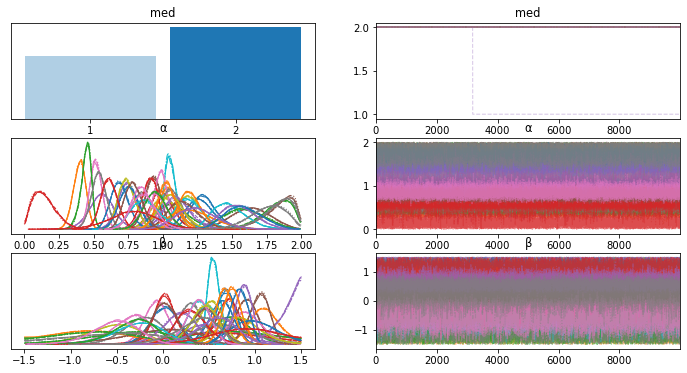

In [74]:
az.plot_trace(trace_beta_n, var_names=['med','α','β'])

In [76]:
az.summary(trace_beta_n, var_names=['α'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.299,0.095,1.150,1.450,0.001,0.000,26436.0,21006.0,1.0
α[1],0.397,0.046,0.325,0.470,0.000,0.000,47618.0,24342.0,1.0
α[2],1.064,0.128,0.863,1.269,0.001,0.001,24129.0,21701.0,1.0
α[3],0.994,0.083,0.860,1.122,0.001,0.000,23282.0,22377.0,1.0
α[4],0.558,0.092,0.412,0.704,0.001,0.000,32638.0,22822.0,1.0
α[5],0.928,0.060,0.836,1.025,0.000,0.000,29963.0,27354.0,1.0
α[6],0.517,0.047,0.441,0.591,0.000,0.000,28142.0,27537.0,1.0
α[7],0.860,0.087,0.727,0.999,0.000,0.000,32913.0,25202.0,1.0
α[8],1.018,0.101,0.852,1.170,0.001,0.000,27267.0,22828.0,1.0
α[9],1.057,0.046,0.987,1.127,0.000,0.000,24290.0,20856.0,1.0


In [40]:
az.compare({'SV':trace_beta, 'SV n': trace_beta_n})

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape par

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
SV n,0,-1170.921217,128.651927,0.000000,1.0,38.530214,0.00000,True,log
SV,1,-1171.627472,129.089111,0.706255,0.0,38.544390,0.34294,True,log


In [112]:
alpha = az.summary(trace_beta_n, var_names=['α'])[['mean']]
beta = az.summary(trace_beta_n, var_names=['β'])[['mean']]

alpha = alpha.rename(columns={'mean': "alpha_med"}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_med"}).reset_index(drop=True)

alpha['sub'] = db['sub'].unique()
beta['sub'] = db['sub'].unique()

output = alpha.merge(beta, left_on='sub', right_on='sub')
output.to_csv('data/med_a.csv')

In [41]:
with pm.Model() as RiskAmb_Beta_age:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    med = pm.DiscreteUniform("med", lower=0, upper=4)
    age = pm.Normal('age', 0, 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = ((db['value'].values * med) ** (α[sub_idx]  + age * db['ageZ'].values)) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 1*med ** (α[sub_idx]  + age * db['ageZ'].values)
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [med]
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, age, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 600 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [42]:
with pm.Model() as RiskAmb_Beta_age_b:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    med = pm.DiscreteUniform("med", lower=0, upper=4)
    agea = pm.Normal('agea', 0, 1)
    ageb = pm.Normal('ageb', 0, 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = ((db['value'].values * med) ** (α[sub_idx]  + agea * db['ageZ'].values)) * (db['risk'].values - ((β[sub_idx]  + agea * db['ageZ'].values) * (db['ambiguity'].values/2)))
    svRef = 1*med ** (α[sub_idx]  + agea * db['ageZ'].values)
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace_beta_age_b = pm.sample(4000, return_inferencedata=True, nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [med]
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, ageb, agea, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 608 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [43]:
az.compare({'SV':trace_beta, 'SV age a': trace_beta_age, 'SV age ab': trace_beta_age_b})

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape par

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
SV age a,0,-1170.956023,128.650727,0.000000,1.0,38.460454,0.000000,True,log
SV,1,-1171.627472,129.089111,0.671449,0.0,38.544390,0.629930,True,log
SV age ab,2,-1172.712103,130.333303,1.756080,0.0,38.716353,1.019509,True,log


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

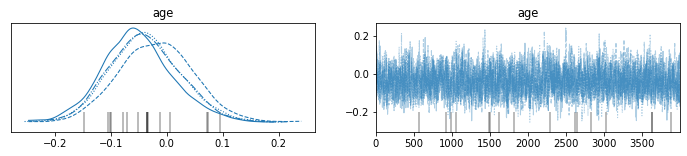

In [70]:
az.plot_trace(trace_beta_age, var_names=['age'])

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


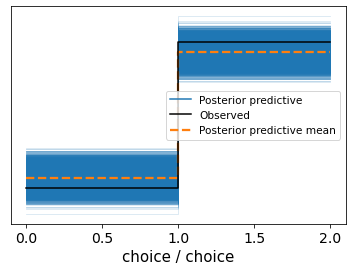

In [55]:
with RiskAmb_Beta_age:
    ppc = pm.sample_posterior_predictive(trace_beta_age)

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb_Beta_age))

In [56]:
az.summary(trace_beta_age, var_names=['age'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,-0.037,0.065,-0.143,0.064,0.003,0.002,645.0,3676.0,1.02


In [64]:
df = db.groupby(['sub','value','risk','ambiguity','ageZ']).mean()
df = df.reset_index()
df = df.drop(['age','moca_score','subn','age1','Unnamed: 0','catch'], axis=1)


In [77]:
alpha = az.summary(trace_beta_n, var_names=['α'])[['mean']]
beta = az.summary(trace_beta_n, var_names=['β'])[['mean']]
#age = az.summary(trace_beta_age, var_names=['age'])[['mean']]

#agea = float(age.iloc[0])

In [78]:
alpha = alpha.rename(columns={'mean': "alpha_pymc"}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_pymc"}).reset_index(drop=True)

alpha['sub'] = db['sub'].unique()
beta['sub'] = db['sub'].unique()

df_age = df.merge(alpha, left_on='sub', right_on='sub')
df_age = df_age.merge(beta, left_on='sub', right_on='sub')

df_age.head()

,sub,value,risk,ambiguity,ageZ,choice,alpha_pymc,beta_pymc
0,10,1,0.25,0.00,-1.627572,0.0,1.299,0.676
1,10,1,0.50,0.00,-1.627572,0.0,1.299,0.676
2,10,1,0.50,0.24,-1.627572,0.0,1.299,0.676
3,10,1,0.50,0.50,-1.627572,0.0,1.299,0.676
4,10,1,0.50,0.74,-1.627572,0.0,1.299,0.676


In [81]:
pg.corr(df_age.ageZ,df_age.alpha_pymc)

,n,r,CI95%,p-val,BF10,power
pearson,1151,-0.137369,"[-0.19, -0.08]",0.000003,2052.93,0.996794


In [88]:
a = alpha.merge(db, left_on='sub', right_on='sub')
a = a.drop_duplicates(['sub'])
a['sex'] = a['gender'].map({'F':1, 'M':0})
a.head()

,alpha_pymc,sub,Unnamed: 0,choice,value,risk,ambiguity,catch,gender,age,moca_score,subn,ageZ,age1,sex
0,1.299,10,83,0,2,0.25,0.00,0.0,M,18,28,0,-1.627572,0.18,0.0
84,0.397,11,0,0,1,0.50,0.00,0.0,F,43,26,1,-0.479172,0.43,1.0
167,1.064,13,59,0,1,0.50,0.50,3.0,F,48,28,2,-0.249492,0.48,1.0
251,0.994,14,82,0,4,0.50,0.74,0.0,F,26,30,3,-1.260084,0.26,1.0
335,0.558,15,60,1,3,0.75,0.00,3.0,F,58,26,4,0.209868,0.58,1.0


In [92]:
pg.partial_corr(data=a, x='alpha_pymc', y='moca_score')#, covar=['moca_score'])

,n,r,CI95%,p-val
pearson,48,0.311869,"[0.03, 0.55]",0.030938


In [97]:
import scipy as sp


Text(0.1, 30, 'r = 0.31, p = 0.03')

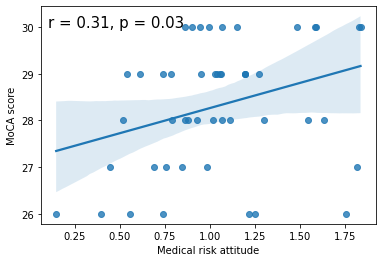

In [107]:
sns.regplot(x='alpha_pymc', y='moca_score', data=a)
plt.xlabel('Medical risk attitude')
plt.ylabel('MoCA score')
#plt.title('Medical risk attitude')

corr = (sp.stats.pearsonr(a.alpha_pymc, a.moca_score))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
plt.text(0.1, 30, text, fontsize=15)

In [79]:
pp = []

for i in range(df_age.shape[0]):
    sub = df_age['sub'][i]
    #ageZ = df_age['ageZ'][i]
    a = float(alpha[alpha['sub']==sub]['alpha_pymc']) #+ agea * ageZ
    b = float(beta[beta['sub']==sub]['beta_pymc'])
    svLotto = (df_age.risk[i] + b * df_age.ambiguity[i]/2) * df_age.value[i] ** a
    svRef   = 5 ** a
    p = special.expit((svLotto - svRef))
    pp.append(p)


In [80]:
df_age['pred']=pp
np.corrcoef(df_age.choice, df_age.pred)

array([[ 1.        , -0.17022625],
       [-0.17022625,  1.        ]])

In [69]:
df_age.to_csv('data/model_med.csv')